In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string   # libreria de cadena de caracteres
import contractions

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report


# Objetos de sklearn para hacer tópicos
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf

# Normalizador
from sklearn.preprocessing import Normalizer 

# Algoritmos de descomposición de tópicos
from sklearn.decomposition import NMF 
from sklearn.decomposition import LatentDirichletAllocation

# Importamos nltk para extraer stopwords 
import nltk 
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

# Librería para hacer wordclouds
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nacho/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nacho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# cargamos el dataframe de entrenamiento y el dataframe de testeo
filename_train = '/home/nacho/Documentos/Python/BooksReviews/goodreads_train.csv' 
filename_test = '/home/nacho/Documentos/Python/BooksReviews/goodreads_test.csv'

df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

In [4]:
df_test=df_test.drop_duplicates()

df_train=df_train.drop_duplicates()

In [5]:
df_sincero = df_train[df_train['rating']!=0].copy().reset_index(drop = True)
len(df_sincero)

869012

In [6]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = contractions.fix(text)
    
    # pasa las mayusculas del texto a minusculas
    text = text.lower()
    #Eliminar citas
    text = re.sub(r'"[^"]*"','', text)
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    # reemplaza signos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)
    
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text

In [7]:
data = df_sincero.copy()

In [8]:
round0 = lambda x: clean_text(x)

# Dataframe que resulta de aplicarle a las columnas la funcion de limpieza
review_text = pd.DataFrame(data.review_text.apply(round0))

data.drop('review_text', axis=1, inplace=True)

data['review_text'] = review_text

del(review_text)

NMF

In [9]:
lemmatizer = WordNetLemmatizer() # funcion para lematizar
sw = nltk.corpus.stopwords.words('english') # lista de stopwords

In [10]:
def remove_sw(text):
    words = text.split(' ') # separamos por espacios
    words_clean = []
    for w in words:
        if not w in sw: # si no es stopword, agregamos la version lematizada
            words_clean.append(lemmatizer.lemmatize(w))
    return ' '.join(words_clean)

round3 = lambda x: remove_sw(x)
 
review_text =  pd.DataFrame(data.review_text.apply(round3))

data.drop('review_text', axis=1, inplace=True)

data['review_text'] = review_text

del(review_text)

In [11]:
df = data.copy()

# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y 
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['review_text'])

# Dimensions de la matriz doc-tér
print(x_count.shape)

(869012, 125340)


In [12]:
# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

In [13]:
# Elijamos la cantidad de tópicos
n_components = 5

# Construímos el objeto NMF con los tópicos indicados 
nmf = NMF(n_components = n_components)

# Aplicamos sobre nuestros datos
x_nmf = nmf.fit_transform(x_tfidf)

# Dimensión de la matriz transformada

print(x_nmf.shape)

(869012, 5)


In [14]:
# Objeto índice: término de nuestro vocabulario
vocabulary = {item: key for key, item in count.vocabulary_.items()}

# Para cada componente
for n in range(n_components):

    # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
    list_sorted = sorted(range(nmf.components_.shape[1]), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

    # Printeamos los términos asociados a los valores más grande de cada una de las componentes
    print(', '.join([vocabulary[i] for i in list_sorted]))
    print('\n')

like, story, really, character, would, one, thing, time, get, much


review, come, full, soon, coming, follow, blog, later, write, see


series, read, one, love, wait, next, cannot, first, great, good


loved, love, absolutely, amazing, story, much, great, wait, cannot, character


star, rating, actual, really, give, ending, romance, good, liked, five




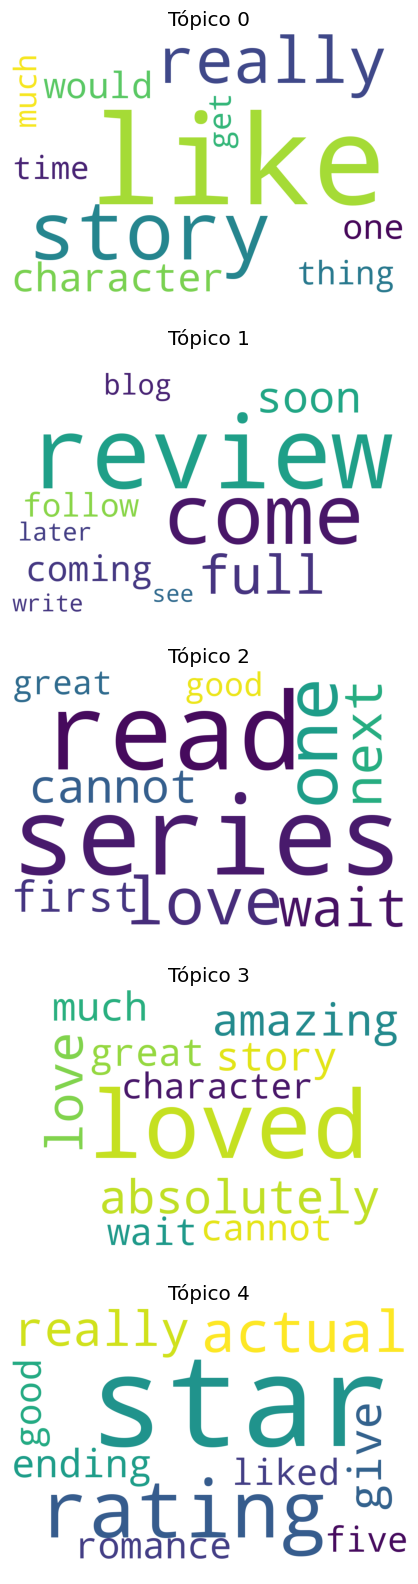

In [15]:
plt.style.use('ggplot')

# WordClouds
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

# Creo la figura
fig, axs = plt.subplots(n_components, figsize = (6,20))

# Recorro para todas las componentes
for n in range(n_components):

    # 10 términos más pesados
    list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

    # Diccionario término: peso
    comp_dict = {vocabulary[i]: nmf.components_[n][i] for i in list_sorted}

    # Creo el wordlcoud
    wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(comp_dict)

    axs[n].set_title('Tópico {}'.format(n))
    axs[n].imshow(wc)
    axs[n].axis('off')

plt.show()

In [16]:
# Creamos un objeto para normalizar a que la suma dé 1
norm = Normalizer('l1')

# Sobreescribimos sobre la matriz de documentos-tópicos
x_nmf = norm.fit_transform(x_nmf)

# Guardemos en el dataframe esta información
for n in range(n_components):
    df['nmf_comp{}'.format(n)] = x_nmf[:,n]

df_rating = df.groupby('rating').mean()

/tmp/ipykernel_20631/1279864029.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rating = df.groupby('rating').mean()


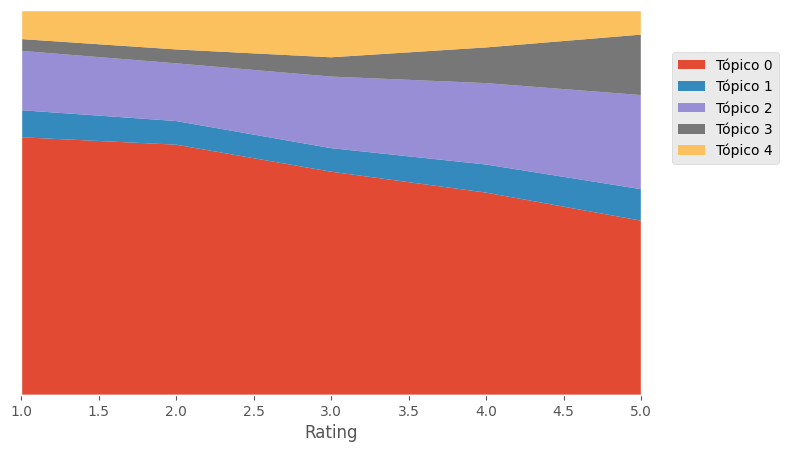

In [18]:
plt.style.use('ggplot')

# El eje x es la década
x = df_rating.index

# El eje y son las distribuciones
y = df_rating[['nmf_comp{}'.format(i) for i in range(n_components)]].to_numpy()

plt.figure(figsize = (8,5))
plt.stackplot(x, y.T) # Stackplot: sirve para graficar distribuciones
plt.xlim([1, 5])
plt.ylim([0, 1.00])
plt.yticks([])
plt.xlabel('Rating')
plt.legend(['Tópico {}'.format(i) for i in range(n_components)], loc = (1.05, 0.60))
plt.show()

Train-Test Split

In [23]:
pd.DataFrame(df).to_csv('df_total.csv')

In [24]:
df.to_csv('/home/nacho/Documentos/Python/BooksReviews/df_totales.csv')

In [3]:
filename_totales = '/home/nacho/Documentos/Python/BooksReviews/df_totales.csv'

df = pd.read_csv(filename_totales)

In [55]:
df[df.rating.eq(6)]

,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_text,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4


In [4]:
def train_test_split(df):
    valcounts = df['rating'].value_counts()
    df_test = df.copy()
    
    for i in range(1, len(valcounts)+1):
        indx_tot = df[df.rating.eq(i)].index
        indx_dif = []
        indx = df[df.rating.eq(i)].sample(int(valcounts[i]*0.3)).index
        df.drop(indx, inplace=True)
        for val in indx_tot:
            if val not in indx:
                indx_dif.append(val)
        df_test.drop(indx_dif, inplace=True)
    print('Train set values:')
    print(df['rating'].value_counts())
    print('Test set values:')
    print(df_test['rating'].value_counts())
    return(df, df_test)

df_train, df_test = train_test_split(df)

Train set values:
4    219582
5    185505
3    132281
2     50839
1     20103
Name: rating, dtype: int64
Test set values:
4    94106
5    79502
3    56691
2    21788
1     8615
Name: rating, dtype: int64


In [5]:
# Armo el vector de etiquetas
y_train = df_train['rating']
y_test = df_test['rating']

# vamos a entrenar un modelo usando únicamente variables 
columnas_reviews = ['book_id', 'n_votes','n_comments', 'nmf_comp0','nmf_comp1','nmf_comp2','nmf_comp3','nmf_comp4']

# extraigo la matriz de features X
X_train = df_train[columnas_reviews]
X_test = df_test[columnas_reviews]

# pruebo con un random forest así como viene de fábrica
clf = RandomForestClassifier()  

# ajusto el modelo
clf=clf.fit(X_train, y_train)

In [6]:
y_prob =  clf.predict(X_test)

print(('NMF + Random Forest Classifier').center(62))
print(('(Lematizado y sin nivelar)').center(62), '\n')
print(classification_report(y_test,y_prob))

                NMF + Random Forest Classifier                
                  (Lematizado y sin nivelar)                   

              precision    recall  f1-score   support

           1       0.11      0.03      0.04      8615
           2       0.16      0.06      0.09     21788
           3       0.31      0.27      0.29     56691
           4       0.38      0.47      0.42     94106
           5       0.48      0.52      0.50     79502

    accuracy                           0.39    260702
   macro avg       0.29      0.27      0.27    260702
weighted avg       0.37      0.39      0.38    260702

